In [1]:
import torch
import random
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data import Dataset 
import torch.nn.utils as utils
import time
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import Levenshtein as lev
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

import seaborn as sns
import random

In [127]:
LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ','<eos>']

In [128]:
print(len(LETTER_LIST))

34


In [4]:
!nvidia-smi

Thu May  6 08:16:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def create_dictionaries(letter_list):
    letter2index = {}
    index2letter = {}
    for i in range(0,len(letter_list)):
        letter2index[letter_list[i]]=i
        index2letter[i]=letter_list[i]
    
    return letter2index, index2letter

letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [6]:
df = pd.read_table("knnw_en_sub.csv", sep = ";", header=0)
idx_text = []
for i in range(df.shape[0]):
    text = df.iloc[i][3].lower()
    split_text = text.split()
    
    l = []
    for word in split_text:
        if word[0] == "[" or word[-1] == ":": #remove speaker name and noise
            continue
        for c in word:
            if c == 'é':
                c = 'e'
            if c == "“" or c == "”":
                c = '"'
            if c in letter2index:
                l.append(letter2index[c])
        l.append(letter2index[' '])#Space between the words use letter2index
    l=l[:-1]
    l.append(letter2index['<eos>'])#End of the sentence
    idx_text.append(l)
df['idx_text'] = idx_text
print(df.head())
    

   Number  Start time in milliseconds  End time in milliseconds  \
0       1                        1650                     10800   
1       2                       53940                     58090   
2       3                       58700                     61440   
3       4                       62060                     66540   
4       5                       66540                     69550   

                                                Text  \
0                                   TOHO CORPORATION   
1  Some mornings, I wake up crying without knowin...   
2      That's when everything happens now and again.   
3  Whatever that dream was I had, I can never rem...   
4                                  - But... - But...   

                                            idx_text  
0  [20, 15, 8, 15, 41, 3, 15, 18, 16, 15, 18, 1, ...  
1  [19, 15, 13, 5, 41, 13, 15, 18, 14, 9, 14, 7, ...  
2  [20, 8, 1, 20, 19, 41, 23, 8, 5, 14, 41, 5, 22...  
3  [23, 8, 1, 20, 5, 22, 5, 18, 41, 20, 

In [7]:
file = open("speakers.srt", "r")
lines = file.readlines()
file.close()
count = 2
speakers = []

for line in lines:
    if line.startswith(str(count)):
        count = count + 1
        speakers.append(line)

name_list = []
for i in range(2, len(speakers)+2):
    new_str = speakers[i-2].replace(str(i), '')
    new_str = new_str.replace('\n', '')
    new_str = new_str.replace(' ', '')
    new_str = new_str.replace(',', '')
    speakers[i-2] = new_str
    if '+' in new_str:
        new_str = new_str.split('+')
        for name in new_str:
            if name not in name_list:
                name_list.append(name)
    else:
        if new_str not in name_list:
            name_list.append(new_str)
print(len(name_list))
name_dict = {}
for i in range(len(name_list)):
    name_dict[name_list[i]] = i
print(name_dict)

speakers = ['None'] + speakers
print(len(speakers))

speaker_label = []
for i in range(len(speakers)):
    l = np.zeros(52)
    if '+' in speakers[i]:
        new_str = speakers[i].split('+')
        for n in new_str:
            l[name_dict[n]] = 1
    else:
        if speakers[i] != 'None':
            l[name_dict[speakers[i]]] = 1
    
    speaker_label.append(l)
speaker_label = np.array(speaker_label)
print(speaker_label.shape)

52
{'Mitsuha': 0, 'Taki': 1, 'Band': 2, 'Yotsuha': 3, 'Grandma': 4, 'Yatsuha': 5, 'Radio': 6, 'None': 7, 'TV': 8, 'Saya': 9, 'Teshi': 10, 'Toshiki': 11, 'BystanderA': 12, 'BystanderB': 13, 'StudentA': 14, 'BystanderC': 15, 'BystanderD': 16, 'StudentB': 17, 'StudentC': 18, 'Sara': 19, 'Teacher': 20, 'StudentD': 21, 'Class': 22, 'Foreman': 23, 'BackCharA': 24, 'BackCharB': 25, 'TeshiMom': 26, 'BystanderE': 27, 'BystanderF': 28, 'TakiDad': 29, 'Crowd': 30, 'Tsukasa': 31, 'Shinta': 32, 'Kitchen': 33, 'Customers': 34, 'Okudera': 35, 'Staff': 36, 'Phone': 37, 'Takagi': 38, 'Waitress': 39, 'Chef': 40, 'Futaba': 41, 'MitsuhaMom': 42, 'Gradnma': 43, 'Shopkeeper': 44, 'Mistuha': 45, 'Kids': 46, 'Conductor': 47, 'TownHall': 48, 'Firefighters': 49, 'TeshiDad': 50, 'TrainAnnouncer': 51}
1393
(1393, 52)


In [8]:
total_frames = 629570
# total_frames = 199864
total_duration=6396010
duration_per_frame = total_duration / total_frames
audio = np.load("log_spectrogram.npy")
# audio = np.load("knnw16000.npy")
print(audio.shape)

def get_index(time, start_flag):
    if start_flag == True:
        return np.floor(time/duration_per_frame)
        
    else:
        return np.ceil(time/duration_per_frame)
        
def get_range(start_time, end_time):
        
    start_index = get_index(start_time, start_flag=True)
    stop_index  = get_index(end_time, start_flag=False)
        
    return range(int(start_index), int(stop_index))

temp = []
for i in range(df.shape[0]):
    
    start_time = df.iloc[i][1]
    stop_time = df.iloc[i][2]
    
    audio_range = get_range(start_time, stop_time)
    audio_item = torch.as_tensor(audio[:,audio_range]).float().permute(1,0)
    temp.append([audio_item, df.iloc[i][4]])
print(len(temp))

temp_speaker = []
for i in range(df.shape[0]):
    
    start_time = df.iloc[i][1]
    stop_time = df.iloc[i][2]
    
    audio_range = get_range(start_time, stop_time)
    audio_item = torch.as_tensor(audio[:,audio_range]).float().permute(1,0)
    temp_speaker.append([audio_item, speaker_label[i]])
print(len(temp_speaker))
    

(129, 629570)
1393
1393


In [41]:
random.shuffle(temp)
print(len(temp))
audio_array = []
idx_text = []
for i in range(len(temp)):
    audio_array.append(temp[i][0])
    idx_text.append(temp[i][1])
print(len(audio_array))
print(len(idx_text))

random.shuffle(temp_speaker)
print(len(temp_speaker))
audio_speaker = []
speaker_label = []
for i in range(len(temp_speaker)):
    audio_speaker.append(temp_speaker[i][0])
    speaker_label.append(temp_speaker[i][1])
print(len(audio_speaker))
print(len(speaker_label))
speaker_label = np.array(speaker_label)

1393
1393
1393
1393
1393
1393


In [64]:
class Speech2TextDataset(Dataset):
    '''
    Dataset class for the speech to text data, this may need some tweaking in the
    getitem method as your implementation in the collate function may be different from
    ours. 
    '''
    def __init__(self, speech, text=None, speaker=None, isTrain=True):
        self.speech = speech
        self.speaker = speaker
        self.isTrain = isTrain
        if (text is not None):
            self.text = text

    def __len__(self):
        return len(self.speech)

    def __getitem__(self, index):
        if (self.isTrain == True):
            return self.speech[index], torch.tensor(self.text[index]), torch.tensor(self.speaker[index].astype(np.long))
        else:
            return self.speech[index]

def collate_train(batch_data):
    #This batch will contain the speech,speech len and the text,text len
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    X = []
    Xlen = []
    Y = []
    Ylen = []
    Z = []
    Zlen = []
    #print("Length of batch data :",len(batch_data))
    for i in range(len(batch_data)):
        X.append(batch_data[i][0])
        Xlen.append(len(batch_data[i][0]))
        Y.append(batch_data[i][1])
        Ylen.append(len(batch_data[i][1]))
        Z.append(batch_data[i][2])
        Zlen.append(len(batch_data[i][2]))
        
    Xpad=pad_sequence(X, batch_first=True)#(B, T, C) 
    Ypad=pad_sequence(Y, batch_first=True)#(B, T, C) 
    Zpad=pad_sequence(Z, batch_first=True)
    
    return Xpad,torch.tensor(Xlen),Ypad,torch.tensor(Ylen), Zpad,torch.tensor(Zlen)

In [65]:
batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed= 11785

In [66]:
split = int(validation_split * len(audio_array))
train_dataset = Speech2TextDataset(audio_array[split:], idx_text[split:], speaker_label[split:])
valid_dataset = Speech2TextDataset(audio_array[:split], idx_text[:split], speaker_label[:split])
print(len(train_dataset))
print(len(valid_dataset))

1115
278


In [67]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_train,num_workers=8,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_train,num_workers=8,pin_memory=True)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [68]:
len(train_loader)

9

In [69]:
len(valid_loader)

3

In [70]:
from torch.autograd import Variable
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.2):
        # x': (B, L, C)
#         if dropout == 0 or not self.training:
#             return x
        mask = x.data.new(x.size(0), 1, x.size(2))
        mask = mask.bernoulli_(1 - dropout)
        mask = Variable(mask, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        
        return mask * x

In [71]:
class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lens):
        '''
        :param query :(batch_size, hidden_size) Query is the output of LSTMCell from Decoder
        :param keys: (batch_size, max_len, encoder_size) Key Projection from Encoder
        :param values: (batch_size, max_len, encoder_size) Value Projection from Encoder
        :return context: (batch_size, encoder_size) Attended Context
        :return attention_mask: (batch_size, max_len) Attention mask that can be plotted 
        
        '''
        attention = torch.bmm(key, query.unsqueeze(2)).squeeze(2)

        mask = torch.arange(key.size(1)).unsqueeze(0) >= lens.unsqueeze(1)
        mask=mask.to(device)
        attention.masked_fill_(mask, -1e9)
        attention = nn.functional.softmax(attention, dim=1)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)

        return context, attention
        


In [72]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    The length of utterance (speech input) can be hundereds to thousands of frames long.
    The Paper reports that a direct LSTM implementation as Encoder resulted in slow convergence,
    and inferior results even after extensive training.
    The major reason is inability of AttendAndSpell operation to extract relevant information
    from a large number of input steps.
    '''
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.1):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=2,dropout=dropout_rate, bidirectional=True,batch_first=True)
        self.lockdrop = LockedDropout()
        self.dropout=dropout_rate

    def forward(self, x):
        '''
        :param x :(N, T) input to the pBLSTM
        :return output: (N, T, H) encoded sequence from pyramidal Bi-LSTM 
        '''
        #First we unpack the sequence
        x_pad,x_len=utils.rnn.pad_packed_sequence(x,batch_first=True)

        x_pad = self.lockdrop(x_pad, self.dropout)
        x_pad=x_pad[:,:(x_pad.shape[1]//2)*2,:]
        
        x_pad = x_pad.contiguous().view(x_pad.shape[0],int(x_pad.shape[1]//2),x_pad.shape[2]*2)        

        #print("Shape of output after x_pad :",x_pad.shape)
        x_len=x_len//2

        #Now we pack this back to send it off to the LSTM
        x_pack = utils.rnn.pack_padded_sequence(x_pad, lengths=x_len, batch_first=True, enforce_sorted=False)

        output, _ = self.blstm(x_pack)
        
        return output

In [73]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key and value.
    Key and value are nothing but simple projections of the output from pBLSTM network.
    '''
    def __init__(self, input_dim, hidden_dim, value_size=256,key_size=256,dropout_rate=0.0,dropouti=0):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=256, num_layers=5, dropout=0.5, bidirectional=True,batch_first=True)

        self.pBLSTM1=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        self.pBLSTM2=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        self.pBLSTM3=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        
        self.key_network = nn.Linear(hidden_dim*2, value_size)
        self.value_network = nn.Linear(hidden_dim*2, key_size)
        
        self.dropout=dropouti
        self.lockdrop = LockedDropout()


    def forward(self, x, lens):
        rnn_inp = utils.rnn.pack_padded_sequence(x, lengths=lens, batch_first=True, enforce_sorted=False)
        dia_input, _ = self.lstm(rnn_inp)
        
        outputs=self.pBLSTM1(dia_input)
        outputs=self.pBLSTM2(outputs)
        outputs=self.pBLSTM3(outputs)
        
        linear_input,encoder_lens = utils.rnn.pad_packed_sequence(outputs,batch_first=True)
        
        linear_input = self.lockdrop(linear_input, self.dropout)
        keys = self.key_network(linear_input)
        value = self.value_network(linear_input)

        return keys, value,encoder_lens, dia_input


In [74]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step, 
    thus we use LSTMCell instead of LSLTM here.
    The output from the second LSTMCell can be used as query here for attention module.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, hidden_dim, value_size=256, key_size=256):
        super(Decoder, self).__init__()
        hidden_dim=key_size + value_size
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=letter2index['<eos>'])
        self.lstm1 = nn.LSTMCell(input_size=768, hidden_size=256)
        self.lstm2 = nn.LSTMCell(input_size=256, hidden_size=key_size)
        
        self.attention = Attention()

        self.character_prob = nn.Linear(key_size + value_size, vocab_size)
        self.value_size=value_size 
        self.embedding.weight=self.character_prob.weight
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.character_prob.bias.data.zero_()
        self.character_prob.weight.data.uniform_(-initrange, initrange)


    def forward(self, epoch,batch_idx,encoder_lens,teacherForcingRate,key, values, text=None, isTrain=True):
        '''
        :param key :( N,T, key_size) Output of the Encoder Key projection layer
        :param values: (N, T,value_size) Output of the Encoder Value projection layer
        :param text: (N, text_len) Batch input of text with text_length
        :param isTrain: Train or eval mode
        :return predictions: Returns the character perdiction probability 
        '''
        batch_size = key.shape[0]

        if (isTrain == True):
            max_len =  text.shape[1]
            embeddings = self.embedding(text)
        else:
            max_len = 600
            
        total_attention=[]
        predictions = []
        hidden_states = [None, None]
        prediction = torch.zeros(batch_size,1).to(device)
        context = values[:, 0, :].reshape(values.size(0),values.size(2))
        teacherForcingRate=teacherForcingRate 
        
        for i in range(max_len):
            
            if (isTrain):
                #Teacher forcing
                tf = np.random.random()
                if tf > teacherForcingRate :
                    if i==0:
                        char_embed=self.embedding(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']).to(device))
                    else:
                        char_embed = embeddings[:,i-1,:].to(device)#Dimension is of B,1,hidden_dim
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1)).to(device)
                    
            else:
                if i==0:
                    char_embed=self.embedding(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']).to(device))
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1)).to(device)

                
            inp = torch.cat([char_embed, context], dim=1)#Char Embed dim:B,H_ and Context:B,hidden_dim
            hidden_states[0] = self.lstm1(inp, hidden_states[0])

            inp_2 = hidden_states[0][0]
            hidden_states[1] = self.lstm2(inp_2, hidden_states[1])

            ### Compute attention from the output of the second LSTM Cell ###
            output = hidden_states[1][0]
                        
            context,masked_attention=self.attention(output,key,values, encoder_lens)
            total_attention.append(masked_attention.detach().cpu())

            prediction = self.character_prob(torch.cat([output, context], dim=1))
                                                                                 
            predictions.append(prediction.unsqueeze(1))
            
        if batch_idx+1==9:
            
            all_attentions = torch.stack(total_attention, dim=1)
            
            plt.clf()
            
            sns.heatmap(all_attentions[0,:,:], cmap='GnBu')
            plt.show()
            print("all_attentions shape :",all_attentions.shape)
            

        return torch.cat(predictions, dim=1)#B,T,V

In [92]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, hidden_dim, value_size=128, key_size=128, isAttended=True):
        super(Seq2Seq, self).__init__()
        self.dropout_rate=0.1
        self.dropouti=0.1
        self.encoder = Encoder(input_dim,256,256,256,self.dropout_rate,self.dropouti)
        self.decoder = Decoder(vocab_size, hidden_dim,256,256)
        self.fc1 = nn.Linear(512, 52)
        initrange = 0.1
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)

    def forward(self, epoch,batch_idx,teacherForcingRate,speech_input, speech_len, text_input=None, isTrain=True):
        key, value, encoder_lens, dia_input = self.encoder(speech_input, speech_len)
        dia_input,_ = utils.rnn.pad_packed_sequence(dia_input,batch_first=True)
        dia_output = self.fc1(dia_input)
        if (isTrain == True):
            predictions = self.decoder(epoch,batch_idx,encoder_lens,teacherForcingRate,key, value, text_input,isTrain=True)
        else:
            predictions = self.decoder(epoch,batch_idx,encoder_lens,None,key, value, text=None, isTrain=False)
        return predictions, dia_output

In [93]:
def predictions(pred):
    sentence_full=[]
    for sentence in pred:#Taking every sentence
        sent=''
        for char in sentence:
            if char==33:
                break
            else:
                sent+=index2letter[char]
        sentence_full.append(sent)
    return sentence_full

In [94]:
#For computing the distance
def LevScore(preds, targets):
    res = 0.0
    for i in range(len(preds)):
        dist = lev.distance(preds[i], targets[i])
        res += dist
        
    return res#Average Levenstein Distance over the batch

In [95]:
#now we should build the model
print(len(LETTER_LIST))
model = Seq2Seq(input_dim=129, vocab_size=len(LETTER_LIST), hidden_dim=256)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none')
criterion_dia = nn.CrossEntropyLoss(reduction='none')
nepochs = 30

43


In [96]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(129, 256, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
    (pBLSTM1): pBLSTM(
      (blstm): LSTM(1024, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM2): pBLSTM(
      (blstm): LSTM(1024, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM3): pBLSTM(
      (blstm): LSTM(1024, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (key_network): Linear(in_features=512, out_features=256, bias=True)
    (value_network): Linear(in_features=512, out_features=256, bias=True)
    (lockdrop): LockedDropout()
  )
  (decoder): Decoder(
    (embedding): Embedding(43, 512, padding_idx=42)
    (lstm1): LSTMCell(768, 256)
    (lstm2): LSTMCell(256, 256)
    (attention): Attention()
    (character_prob): Linear(in_features=512, out_f

In [121]:
def train(model, train_loader, criterion, optimizer, epoch, teacherForcingRate, criterion_dia):
    model.train()
    model.to(device)
    
    train_loss=0
    dia_loss = 0
    
    
    for batch_idx,(inp,inp_len,target,target_len,speaker,speaker_len) in enumerate(train_loader):
        start = time.time()
        
        # Set the inputs to the device.
        inp,target,speaker = inp.to(device),target.to(device), speaker.to(device)
        
        optimizer.zero_grad()
        output, dia_output = model(epoch,batch_idx,teacherForcingRate,inp, inp_len, target,True)
        
        # Process Diarization Module
        temp = torch.mean(dia_output, 1)
        
        speaker = torch.argmax(speaker, dim=1)
        loss_dia = criterion_dia(temp,speaker)
        
        loss_dia = loss_dia.sum()

        dia_loss += loss_dia.item()
        
        
        # Process Recognition Module
        mask = torch.arange(max(target_len)).unsqueeze(0) >= target_len.int().unsqueeze(1)#Switching Masks
        mask=mask.to(device)

        output.contiguous() 
        loss=criterion(output.view(-1,output.shape[2]),target.contiguous().view(-1))

        loss.masked_fill_(mask.contiguous().view(-1),0)
        
        loss=loss.mean()
        total_loss = loss + loss_dia
        total_loss.backward()

        torch.nn.utils.clip_grad_norm(model.parameters(), 2)

        optimizer.step()

        train_loss+=loss.item()

        del inp
        del inp_len
        del target
        del target_len
        del speaker
        del speaker_len
        stop = time.time()
        torch.cuda.empty_cache()
        
        if batch_idx % 10 == 0:
            print('B: %d / %d, avg_loss: %.3f, avg_loss_dia: %.3f, Time Taken : %.3f, ' % (batch_idx+1, len(train_loader),train_loss/(batch_idx+1),dia_loss/(batch_idx+1),stop-start),end='\n ')
    

def validation(model, valid_loader):
    valid_loss=0
    total_dist_score=0
    model.eval()
    seq_len=0
    dist_score=0
    correct_num = 0
    dia_loss = 0.0
    
    for batch_idx,(inp,inp_len,target,target_len,speaker,speaker_len) in enumerate(valid_loader):
        start = time.time()
        inp,target,speaker = inp.to(device),target.to(device),speaker.to(device)
        
        output, dia_output = model(epoch,batch_idx,None,inp, inp_len, None, False)
        
        temp = torch.mean(dia_output, 1)
        
        speaker = torch.argmax(speaker, dim=1)
        predicted = torch.argmax(temp, dim = 1)
        print(predicted)
        loss_dia = criterion(temp,speaker)
        
        for n in range(len(predicted)):
            if predicted[n] == speaker[n]:
                correct_num += 1
        
        loss_dia = loss_dia.sum()
        dia_loss += loss_dia.item()
        
        pred = predictions(output.argmax(-1).detach().cpu().numpy())
        target = predictions(target.detach().cpu().numpy())
        

        dist_score += LevScore(pred,target)
        seq_len += len(pred)
        
        del inp
        del inp_len
        del target_len
        del speaker
        del speaker_len
        stop = time.time()
        torch.cuda.empty_cache()
    print("prediciton :",pred[2])
    print("Target : ",target[2])
    print('Distance Score: %.3f ' % (dist_score/seq_len),end='\n ')
    print('Loss in Diarization:', dia_loss/seq_len, 'Correct prediction:', correct_num, 'se1_len:', seq_len)
    return dist_score/seq_len, correct_num, dia_loss/seq_len, seq_len

In [122]:
start_epoch=0

In [123]:
# mn = torch.load("epoch33")
# model.load_state_dict(mn['model_state'])
# optimizer.load_state_dict(mn['opti_state'])
# model.to(device)

In [124]:
# for param_group in optimizer.param_groups:
#         param_group['lr'] = 0.0005

In [125]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

Teacher Forcing : 0.15
epoch: 0
0.001


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


B: 1 / 9, avg_loss: 0.699, avg_loss_dia: 505.929, Time Taken : 2.276, 
 

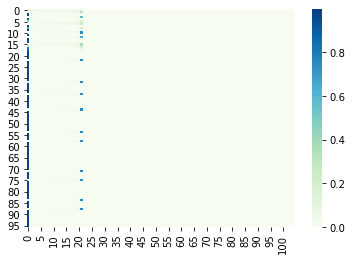

all_attentions shape : torch.Size([91, 96, 105])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

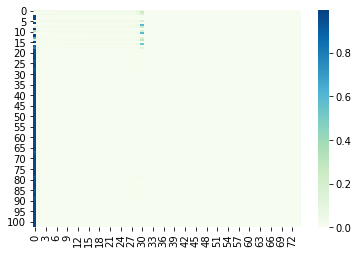

all_attentions shape : torch.Size([91, 103, 75])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

KeyboardInterrupt: 

In [126]:
best_dis = 1000
for epoch in range(10):#New architecture with Encoder hidden dim=256 and Decoder hidden_dim=512 increased and encoder output increased
    
    tf=0.15
        
    print("Teacher Forcing :",tf)
    print("epoch:", epoch)
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    
    train(model, train_loader, criterion, optimizer, epoch,tf, criterion_dia)
    dis, correct, dia_loss, seq_len = validation(model, valid_loader)

#     scheduler.step(dis)
#    torch.save({'model_state': model.state_dict(), 'opti_state': optimizer.state_dict(), 'val_dis': dis}, "epoch"+str(epoch))
  